In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
import wandb

In [14]:
classes = {
    0: 'Dascyllus reticulatuscheck',
    1: 'Plectroglyphidodon dickiicheck',
    2: 'Chromis chrysuracheck',
    3: 'Amphiprion clarkiicheck',
    4: 'Chaetodon lunulatuscheck',
    5: 'Chaetodon trifascialischeck',
    6: 'Myripristis kunteecheck',
    7: 'Acanthurus nigrofuscuscheck',
    8: 'Hemigymnus fasciatuscheck',
    9: 'Neoniphon sammaracheck',
    10: 'Abudefduf vaigiensischeck',
    11: 'Canthigaster valentinicheck',
    12: 'Pomacentrus moluccensischeck',
    13: 'Zebrasoma scopascheck',
    14: 'Hemigymnus melapteruscheck',
    15: 'Lutjanus fulvuscheck',
    16: 'Scolopsis bilineatacheck',
    17: 'Scaridaecheck',
    18: 'Pempheris vanicolensischeck',
    19: 'Zanclus cornutuscheck',
    20: 'Neoglyphidodon nigrorischeck',
    21: 'Balistapus undulatuscheck',
    22: 'Siganus fuscescenscheck',
}

In [15]:
# Custom Dataset Class for Fish Images
class FishClassificationDataset(Dataset):
    def __init__(self, image_folder, transform=None, full_dataset=False):
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.tracking_ids = set()  # To keep track of unique tracking IDs

        # Populate image paths and labels
        for cluster_id in os.listdir(image_folder):
            cluster_path = os.path.join(image_folder, cluster_id)
            if os.path.isdir(cluster_path):
                # Extract the numeric part from the cluster_id (e.g., 'fish_14' -> 14)
                numeric_label = int(cluster_id.split('_')[1]) - 1  # Subtract 1 to start labels from 0 to avoid problems with model loss function
                for img_name in os.listdir(cluster_path):
                    img_path = os.path.join(cluster_path, img_name)
                    # Extract tracking ID from the image filename
                    tracking_id = img_name.split('_')[1]  # Adjust based on your filename format

                    # if tracking_id not in self.tracking_ids or int(tracking_id) >= 10:
                    if tracking_id not in self.tracking_ids or full_dataset:
                        self.tracking_ids.add(tracking_id)
                        self.image_paths.append(img_path)
                        self.labels.append(numeric_label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


# Model Architecture for Multi-Class Classification
class FishClassifier(nn.Module):
    def __init__(self, num_classes):
        super(FishClassifier, self).__init__()
        self.backbone = models.resnet18(weights="ResNet18_Weights.DEFAULT")
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

# Define Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the Dataset
image_folder = 'fish_image'  # Replace with your dataset path
fish_dataset = FishClassificationDataset(image_folder=image_folder, transform=transform)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(fish_dataset))
test_size = len(fish_dataset) - train_size
train_dataset, test_dataset = random_split(fish_dataset, [train_size, test_size])

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Initialize the Model, Loss Function, and Optimizer
num_classes = len(set(fish_dataset.labels))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FishClassifier(num_classes=num_classes).to(device)
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)  # Probability of the true class
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss

# Use FocalLoss as the criterion
# criterion = FocalLoss()

In [18]:
import torch
from collections import Counter

# Calculate class frequencies
class_counts = Counter(fish_dataset.labels)
total_samples = len(fish_dataset)
class_weights = {label: total_samples / count for label, count in class_counts.items()}

# Convert to a tensor and move to the device
weights = torch.tensor([class_weights[label] for label in sorted(class_counts.keys())], dtype=torch.float).to(device)

# Use the weights in CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=weights)

In [19]:
wandb.init(project="fish4", entity="junta")

In [20]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        images, labels = images.to(device), labels.to(device).long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation Loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_outputs = []
    all_labels = []

    with torch.inference_mode():
        for images, labels in tqdm(test_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_outputs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate Metrics
    test_accuracy = 100 * correct / total
    print(f"Training Loss: {running_loss/len(train_loader):.4f} | Validation Loss: {val_loss/len(test_loader):.4f} | Test Accuracy: {test_accuracy:.2f}%")

    # Log metrics to wandb
    wandb.log({
        "training_loss": running_loss / len(train_loader),
        "validation_loss": val_loss / len(test_loader),
        "test_accuracy": test_accuracy
    })

Validation: 100%|██████████| 55/55 [00:03<00:00, 15.71it/s]


Training Loss: 1.4460 | Validation Loss: 0.5143 | Test Accuracy: 89.97%


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.63it/s]


Training Loss: 0.2425 | Validation Loss: 0.4329 | Test Accuracy: 92.38%


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.35it/s]


Training Loss: 0.0751 | Validation Loss: 0.1644 | Test Accuracy: 97.31%


Validation: 100%|██████████| 55/55 [00:03<00:00, 13.90it/s]


Training Loss: 0.0325 | Validation Loss: 0.1464 | Test Accuracy: 98.28%


Validation: 100%|██████████| 55/55 [00:06<00:00,  8.23it/s]


Training Loss: 0.0222 | Validation Loss: 0.1660 | Test Accuracy: 97.94%


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.15it/s]


Training Loss: 0.0127 | Validation Loss: 0.1627 | Test Accuracy: 98.57%


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.12it/s]


Training Loss: 0.0080 | Validation Loss: 0.1641 | Test Accuracy: 98.11%


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.40it/s]


Training Loss: 0.0129 | Validation Loss: 0.1623 | Test Accuracy: 98.57%


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.42it/s]


Training Loss: 0.0300 | Validation Loss: 0.1213 | Test Accuracy: 97.42%


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.39it/s]


Training Loss: 0.0071 | Validation Loss: 0.0977 | Test Accuracy: 97.82%


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.43it/s]


Training Loss: 0.0067 | Validation Loss: 0.1025 | Test Accuracy: 98.80%


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.90it/s]


Training Loss: 0.2743 | Validation Loss: 0.4776 | Test Accuracy: 86.99%


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.54it/s]


Training Loss: 0.4155 | Validation Loss: 0.4365 | Test Accuracy: 86.13%


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.37it/s]


Training Loss: 0.0672 | Validation Loss: 0.1837 | Test Accuracy: 97.48%


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.97it/s]


Training Loss: 0.0132 | Validation Loss: 0.1927 | Test Accuracy: 98.57%


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.89it/s]


Training Loss: 0.0105 | Validation Loss: 0.1856 | Test Accuracy: 98.22%


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.13it/s]


Training Loss: 0.0054 | Validation Loss: 0.1992 | Test Accuracy: 98.28%


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.63it/s]


Training Loss: 0.0058 | Validation Loss: 0.2210 | Test Accuracy: 98.40%


Validation: 100%|██████████| 55/55 [00:03<00:00, 14.33it/s]


Training Loss: 0.0029 | Validation Loss: 0.2051 | Test Accuracy: 98.51%


Validation: 100%|██████████| 55/55 [00:03<00:00, 15.16it/s]

Training Loss: 0.0093 | Validation Loss: 0.2115 | Test Accuracy: 98.51%


In [21]:
torch.save(model.state_dict(), "fish_classifier.pth")

In [22]:
wandb.finish()

test_accuracy,▃▄▇█████▇▇█▁▁▇██████
training_loss,█▂▁▁▁▁▁▁▁▁▁▂▃▁▁▁▁▁▁▁
validation_loss,█▇▂▂▂▂▂▂▁▁▁▇▇▂▃▂▃▃▃▃
test_accuracy,98.51003
training_loss,0.00932
validation_loss,0.21154


In [1]:
import matplotlib.pyplot as plt
import random

# Function to Compute Similarity Scores
def compute_similarity_scores(outputs1, outputs2):
    probs1 = F.softmax(torch.tensor(outputs1), dim=1)
    probs2 = F.softmax(torch.tensor(outputs2), dim=1)
    similarity = F.cosine_similarity(probs1, probs2, dim=1)
    return similarity

# Example of Calculating Similarity Scores and Showing Images
model.eval()
with torch.inference_mode():
    # Get two images and their labels from the dataset
    img1, label1 = fish_dataset[0]  # Get the first image from the dataset
    img2, label2 = fish_dataset[random.randint(0, len(fish_dataset))]  # Get the second image from the dataset

    # Move images to the device and add batch dimension
    img1, img2 = img1.to(device).unsqueeze(0), img2.to(device).unsqueeze(0)

    # Pass the images through the model to get outputs
    outputs1 = model(img1)
    outputs2 = model(img2)

    # Compute similarity score
    similarity_score = compute_similarity_scores(outputs1, outputs2)
    print(f"Similarity Score: {similarity_score.item()}")

    # Move images back to CPU for visualization
    img1_np = img1.squeeze(0).cpu().permute(1, 2, 0).numpy()
    img2_np = img2.squeeze(0).cpu().permute(1, 2, 0).numpy()

    # Normalize the images for display
    img1_np = (img1_np - img1_np.min()) / (img1_np.max() - img1_np.min())
    img2_np = (img2_np - img2_np.min()) / (img2_np.max() - img2_np.min())

    # Plot the images side by side
    fig, axes = plt.subplots(2, 1, figsize=(6, 6))
    axes[0].imshow(img1_np)
    axes[0].axis('off')
    axes[0].set_title(f"Score: {(similarity_score.item()*100):.2f}%\n {classes[label1]}")

    axes[1].imshow(img2_np)
    axes[1].axis('off')
    axes[1].set_title(f"{classes[label2]}")

    plt.tight_layout()
    plt.show()


NameError: name 'model' is not defined

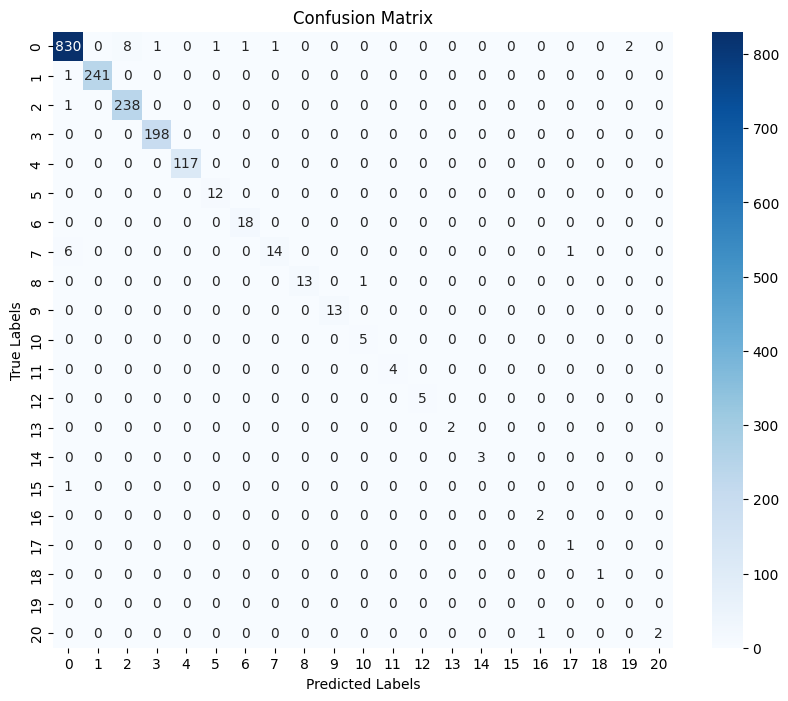

In [24]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect true labels and predictions
all_labels = []
all_predictions = []

model.eval()  # Set the model to evaluation mode
with torch.inference_mode():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class index
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
